# MSES Geometry Manipulation Demo

MSES format is a way of listing surface data (i.e. y vs x or Surface Cp vs x)
for a closed body (i.e. an airfoil) so that all data can be expressed in a
single column.  In the example of y vs x, the two columns begin with an x,y pair
for the upper surface at the trailing edge of the airfoil.  The upper surface
is then traced backwards to the leading edge, where x=0.  x then begins to increase
again, as the lower surface is traced back to the trailing edge.

This demo provides functions to manage MSES file format.  Split MSES files into two
separate data sets for the upper and lower surfaces.

It will also demonstrate how to load an MSES format file produced by XFOIL,
split the data into upper and lower surfaces, and reverse the order of the
upper surface data, so that it goes from smallest to largest x.  Finally,
interpolate split data so that it matches with a user-provided grid.

In [155]:
#STANDARD IMPORTS
import numpy as np
import matplotlib.pyplot as plt

### JUPYTER NOTEBOOK SETTINGS ########################################
#Plot all figures in full-size cells, no scroll bars
%matplotlib inline 
#Disable Python Warning Output 
#(NOTE: Only for production, comment out for debugging)
import warnings
warnings.filterwarnings('ignore')


########################################################################
### CUSTOM PLOTTING DEFAULTS (OPTIONAL) ################################
########################################################################

### PLOTTING DEFAULTS BOILERPLATE ######################################
#SET DEFAULT FIGURE APPERANCE
import seaborn as sns #Fancy plotting package
#No Background fill, legend font scale, frame on legend
sns.set(style='whitegrid', font_scale=1.5, rc={'legend.frameon': True})
#Mark ticks with border on all four sides (overrides 'whitegrid')
sns.set_style('ticks')
#ticks point in
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
#fix invisible marker bug
sns.set_context(rc={'lines.markeredgewidth': 0.1})
#SET MATPLOTLIB DEFAULTS
    #(call after seaborn, which changes some defaults)
params = {
        #FONT SIZES
        'axes.labelsize' : 30, #Axis Labels
        'axes.titlesize' : 30, #Title
        'font.size'      : 28, #Textbox
        'xtick.labelsize': 22, #Axis tick labels
        'ytick.labelsize': 22, #Axis tick labels
        'legend.fontsize': 24, #Legend font size
        # 'font.family': 'helvetica' #Font family
        'font.family'    : 'serif',
        'font.fantasy'   : 'xkcd',
        'font.sans-serif': 'Helvetica',
        'font.monospace' : 'Courier',
        #AXIS PROPERTIES
        'axes.titlepad'  : 2*6.0, #title spacing from axis
        'axes.grid'      : True,  #grid on plot
        'figure.figsize' : (8,8),   #square plots
        'savefig.bbox'   : 'tight', #reduce whitespace in saved figures
        #LEGEND PROPERTIES
        'legend.framealpha'     : 0.5,
        'legend.fancybox'       : True,
        'legend.frameon'        : True,
        'legend.numpoints'      : 1,
        'legend.scatterpoints'  : 1,
        'legend.borderpad'      : 0.1,
        'legend.borderaxespad'  : 0.1,
        'legend.handletextpad'  : 0.2,
        'legend.handlelength'   : 1.0,
        'legend.labelspacing'   : 0,
}
import matplotlib
matplotlib.rcParams.update(params) #update matplotlib defaults


## Detect Leading Edge Point

The MSES file format specifies the coordinates of an airfoil surface in a 1-dimensional, curvilinear fashion. X and Y (or Z) surface coordinates are listed in order, starting at the trailing edge point on the upper surface of the airfoil and moving along the upper surface towards the leading edge. The list then continues past the leading edge and along the lower surface of the airfoil, ending at the trailing edge point on the lower surface.

When computing airfoil geometry parameters or integrating surface values like pressure distributions, it can be convenient to separate MSES-style data sets into two separate, mapped sets of data for the upper and lower surface. In order to perform this "splitting" operation, it is necessary to know the coordinates of the leading edge point, as this point separates the upper and lower surface.

Detecting this point can be accomplished in a number of ways. This example will use the sign of the rate of change of the horizontal (X) coordinate to determine where a leading edge point is located. 

One potential flaw with this method is that a leading edge point directly on the chord line ($y=0$) should be shared by both the upper and lower surfaces. This is accounted for by employing two "FindLE()" functions that can be found below, which perform the LE location process starting from either end of the airfoil.

In [156]:
def FindLE_top(X):
    """Return index dividing upper and lower surface given MSES geometry.
    Search along upper surface until LE.
    MSES files start at rear of airfoil, and x diminishes until the leading
    edge, where it then increases back to the trailing edge.  This code finds
    the transition where x goes from decreasing to increasing.
    X --> MSES x coordinates
    """
    xold = X[0]
    for i, x in enumerate(X[1:]):
        if x >= xold:
            #If current x greater/equal to prev x, x is increasing (lower surf)
            return i #return index of Leading Edge (divides upper/lower surfs)
        else:
            #If current x less than prev x, x still diminishing (upper surf)
            xold = x

def FindLE_bot(X):
    """Return index dividing upper and lower surface given MSES geometry.
    Search along lower surface until LE.
    MSES files start at rear of airfoil, and x diminishes until the leading
    edge, where it then increases back to the trailing edge.  This code finds
    the transition where x goes from decreasing to increasing.
    X --> MSES x coordinates
    """
    Xreverse = X[::-1]
    xold = Xreverse[0]
    for i, x in enumerate(Xreverse[1:]):
        if x >= xold:
            #If current x greater/equal to prev x, x is increasing (on upper surf)
            return len(X) - 1 - i #return index of Leading Edge (divides upper/lower surfs)
        else:
            #If current x less than prev x, x still diminishing (still on lower surf)
            xold = x

## Load MSES Surface Pressure Distribution from XFOIL

Load surface pressure data from XFOIL (save in MSES format):
    - Unpack columns into individual variables: x, Cp
    - skip first row which contains column titles, not data

In [157]:
loadfile = 'surfPress_mses.dat'
xmses, Cp = np.loadtxt(loadfile, unpack=True, skiprows=1)
print(xmses)

[1.0000e+00 9.9838e-01 9.9417e-01 9.8825e-01 9.8075e-01 9.7111e-01
 9.5884e-01 9.4389e-01 9.2639e-01 9.0641e-01 8.8406e-01 8.5947e-01
 8.3277e-01 8.0412e-01 7.7369e-01 7.4166e-01 7.0823e-01 6.7360e-01
 6.3798e-01 6.0158e-01 5.6465e-01 5.2744e-01 4.9025e-01 4.5340e-01
 4.1721e-01 3.8193e-01 3.4777e-01 3.1488e-01 2.8347e-01 2.5370e-01
 2.2541e-01 1.9846e-01 1.7286e-01 1.4863e-01 1.2591e-01 1.0482e-01
 8.5450e-02 6.7890e-02 5.2230e-02 3.8550e-02 2.6940e-02 1.7550e-02
 1.0280e-02 4.9500e-03 1.5500e-03 5.0000e-05 4.4000e-04 2.6400e-03
 7.8900e-03 1.7180e-02 3.0060e-02 4.6270e-02 6.5610e-02 8.7870e-02
 1.1282e-01 1.4020e-01 1.7006e-01 2.0278e-01 2.3840e-01 2.7673e-01
 3.1750e-01 3.6044e-01 4.0519e-01 4.5139e-01 4.9860e-01 5.4639e-01
 5.9428e-01 6.4176e-01 6.8832e-01 7.3344e-01 7.7660e-01 8.1729e-01
 8.5500e-01 8.8928e-01 9.1966e-01 9.4573e-01 9.6693e-01 9.8255e-01
 9.9268e-01 9.9825e-01 1.0000e+00]


Notice how the MSES list of x-coordinate data starts at -1 (Trailing edge, $\frac{x}{c}=1), then decreases as the coordinates travel along the upper surface towards the leading edge, then return back to 1 (Lower trailing edge) after reaching near-zero at the LE.

## Split MSES Data Into Upper/Lower Surfaces

The surface pressure distribution data we loaded in MSES format can be plotted as-is, but we have no information about the separation of the upper and lower surface. This means we cannot perform the differencing computations necessary to integrate the lift force on this airfoil.

The data can be split into upper/lower surface sets using the following function, which detects the point that corresponds to the leading edge and then divides the MSES data at that point.

In [158]:
def MsesSplit(x, y):
    """Split MSES format into upper and lower surfaces.
    Find LE from MSES x geometry coordinates,
    Split y at this index(s).
    If LE point is at y=0, include in both sets of data.
    Return y split into upper/lower surfaces, with LE overlapping
    x --> MSES x coordinates
    y --> Any other MSES parameter (e.g. x/c, z/c, Cp, etc)
    """
    #FIND LE FROM BOTH SIDES (DETECT SHARED LE POINT)
    #Get index of leading edge starting from upper surface TE
    iLE_top = FindLE_top(x)
    #Get index of leading edge starting from lower surface TE
    iLE_bot = FindLE_bot(x)
    #Split upper and lower surface, reverse order upper surface
    up = y[iLE_top::-1]
    lo = y[iLE_bot:]
    return up, lo

Notice that it requires the horizontal (X) MSES variable as the first input so that it can detect the leading edge point. The second input can be any corresponding MSES variable: X-coordinate, Y-coordinate, surface pressure, etc.

Therefore, in order to split our $X/C_P$ MSES data into separate sets for the upper and lower surface, **we will need to call SplitMses() twice:** once to split $X$ and once to split $C_P$

In [159]:
#Split x data into upper and lower surfaces (using original points)
x_up, x_lo   = MsesSplit(xmses, xmses)
#Split Cp data into upper and lower surfaces (using original points)
Cp_up, Cp_lo = MsesSplit(xmses, Cp)

Recall that the original MSES data for X was one list running from 1 to 1:

In [160]:
print('x before split:')
print('\t(single list running from 1 to 1)')
print(xmses)

x before split:
	(single list running from 1 to 1)
[1.0000e+00 9.9838e-01 9.9417e-01 9.8825e-01 9.8075e-01 9.7111e-01
 9.5884e-01 9.4389e-01 9.2639e-01 9.0641e-01 8.8406e-01 8.5947e-01
 8.3277e-01 8.0412e-01 7.7369e-01 7.4166e-01 7.0823e-01 6.7360e-01
 6.3798e-01 6.0158e-01 5.6465e-01 5.2744e-01 4.9025e-01 4.5340e-01
 4.1721e-01 3.8193e-01 3.4777e-01 3.1488e-01 2.8347e-01 2.5370e-01
 2.2541e-01 1.9846e-01 1.7286e-01 1.4863e-01 1.2591e-01 1.0482e-01
 8.5450e-02 6.7890e-02 5.2230e-02 3.8550e-02 2.6940e-02 1.7550e-02
 1.0280e-02 4.9500e-03 1.5500e-03 5.0000e-05 4.4000e-04 2.6400e-03
 7.8900e-03 1.7180e-02 3.0060e-02 4.6270e-02 6.5610e-02 8.7870e-02
 1.1282e-01 1.4020e-01 1.7006e-01 2.0278e-01 2.3840e-01 2.7673e-01
 3.1750e-01 3.6044e-01 4.0519e-01 4.5139e-01 4.9860e-01 5.4639e-01
 5.9428e-01 6.4176e-01 6.8832e-01 7.3344e-01 7.7660e-01 8.1729e-01
 8.5500e-01 8.8928e-01 9.1966e-01 9.4573e-01 9.6693e-01 9.8255e-01
 9.9268e-01 9.9825e-01 1.0000e+00]


After calling MsesSplit(), our X data is now split into two variables, each running from 0 to 1

In [161]:
print('x after split:')
print('\t(two lists, each from ~0 to 1)')
print(x_up)
print(x_lo)

x after split:
	(two lists, each from ~0 to 1)
[5.0000e-05 1.5500e-03 4.9500e-03 1.0280e-02 1.7550e-02 2.6940e-02
 3.8550e-02 5.2230e-02 6.7890e-02 8.5450e-02 1.0482e-01 1.2591e-01
 1.4863e-01 1.7286e-01 1.9846e-01 2.2541e-01 2.5370e-01 2.8347e-01
 3.1488e-01 3.4777e-01 3.8193e-01 4.1721e-01 4.5340e-01 4.9025e-01
 5.2744e-01 5.6465e-01 6.0158e-01 6.3798e-01 6.7360e-01 7.0823e-01
 7.4166e-01 7.7369e-01 8.0412e-01 8.3277e-01 8.5947e-01 8.8406e-01
 9.0641e-01 9.2639e-01 9.4389e-01 9.5884e-01 9.7111e-01 9.8075e-01
 9.8825e-01 9.9417e-01 9.9838e-01 1.0000e+00]
[5.0000e-05 4.4000e-04 2.6400e-03 7.8900e-03 1.7180e-02 3.0060e-02
 4.6270e-02 6.5610e-02 8.7870e-02 1.1282e-01 1.4020e-01 1.7006e-01
 2.0278e-01 2.3840e-01 2.7673e-01 3.1750e-01 3.6044e-01 4.0519e-01
 4.5139e-01 4.9860e-01 5.4639e-01 5.9428e-01 6.4176e-01 6.8832e-01
 7.3344e-01 7.7660e-01 8.1729e-01 8.5500e-01 8.8928e-01 9.1966e-01
 9.4573e-01 9.6693e-01 9.8255e-01 9.9268e-01 9.9825e-01 1.0000e+00]


The same is true for our $C_P$ data, which is mapped directly to the split X data

In [162]:
print('\nCp before split:')
print(Cp)

print('\nafter split:')
print(Cp_up, Cp_lo)


Cp before split:
[ 0.36027  0.30899  0.07821 -0.31834 -0.74051 -0.88774 -0.84217 -0.83459
 -0.82507 -0.81499 -0.81172 -0.81227 -0.81392 -0.81964 -0.829   -0.84281
 -0.85712 -0.87679 -0.89643 -0.92202 -0.95197 -0.98859 -1.04312 -1.11214
 -1.20161 -1.30449 -1.41707 -1.5241  -1.68571 -1.79714 -1.82592 -1.83037
 -1.77892 -1.72047 -1.64942 -1.57612 -1.47401 -1.3602  -1.22163 -1.05286
 -0.88105 -0.61036 -0.23257  0.15181  0.53683  0.86306  0.99906  0.48756
  0.04139  0.20564  0.19229  0.20648  0.21048  0.21478  0.21829  0.2185
  0.25345  0.30757  0.34861  0.38484  0.41689  0.44484  0.46964  0.49134
  0.51115  0.52795  0.54308  0.55671  0.56857  0.57918  0.58888  0.59688
  0.60414  0.61008  0.61538  0.62034  0.60678  0.55777  0.49788  0.44853
  0.36027]

after split:
[ 0.86306  0.53683  0.15181 -0.23257 -0.61036 -0.88105 -1.05286 -1.22163
 -1.3602  -1.47401 -1.57612 -1.64942 -1.72047 -1.77892 -1.83037 -1.82592
 -1.79714 -1.68571 -1.5241  -1.41707 -1.30449 -1.20161 -1.11214 -1.04312
 -0.98859

We now have the basic capability we need to separate our MSES data.  **However**, if we plot our upper and lower surface pressure distributions data, take a close look at the point overlap between the two sets of data, especially near the leading edge:

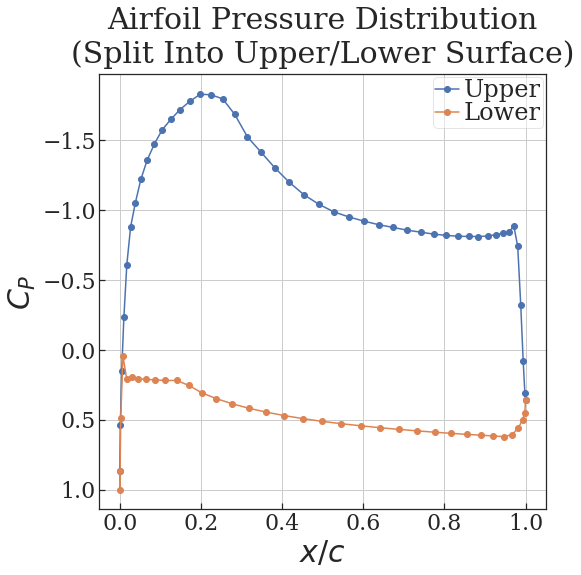

In [163]:
plt.figure()
plt.title('Airfoil Pressure Distribution\n(Split Into Upper/Lower Surface)')
plt.xlabel('$x/c$')
plt.ylabel('$C_P$')

plt.plot(x_up, Cp_up, label="Upper", marker='o')
plt.plot(x_lo, Cp_lo, label="Lower", marker='o')
#invert y axis so that upper surface data is on top of plot (more intuitive)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Notice that some of the points do not align **vertically** between the upper and lower surface. This is because the airfoil geometry was defined at irregular x-intervals in the MSES format. 

This is not an issue for visualizing our surface pressure data, but if we were to integrate the difference in surface pressure along the airfoil to compute our aerodynamic forces, our assumption that the differencing points are vertically aligned would be incorrect, leading to error in our calculation.

This can be remedied by interpolating both the upper and lower surface to a common x-coordinate vector, as demonstrated below

## Split Mses And Interpolate to Common X-Coodinates

Since we usually have the goal of performing calculations with the MSES data that we separate into two surfaces, it is often beneficial to interpolate each set to the same x-coordinate vector. 

The function below will split the MSES data at the leading edge just as before using the MsesSplit() function, then it will interpolate the resulting upper/lower surface data to the new x-vector, provided by the user.

This function can be used as a replacement of MsesSplit().

In [164]:
def MsesInterp(xout, xmses, ymses):
    """Split MSES format data into upper and lower surfaces.  Then
    interpolate data to match given xout vector.
    xout  --> desired x locations
    xmses --> original x MSES data
    ymses --> original x/c, z/c, Cp, etc MSES data
    """
    xup_mses, xlo_mses = MsesSplit(xmses, xmses)
    yup_mses, ylo_mses = MsesSplit(xmses, ymses)
    yup = np.interp(xout, xup_mses, yup_mses)
    ylo = np.interp(xout, xlo_mses, ylo_mses)
    return yup, ylo

To utilize MsesInterp(), we need to create a new x-vector to interpolate each side to. 

This new vector should run from the Leading Edge ($\sfrac{x}{c}=0$) to the Trailing Edge ($\sfrac{x}{c}=1$) and should have enough points for accurate numeric interation and geometry representation in plots.

In [165]:
#Make x-grid to interpolate Cp with (map Cp to your own points)
xnew = np.linspace(0, 1, 101) #make new points

Then, we call MsesInterp() to split and interpolate our upper and lower surface data, and plot the result, as before:

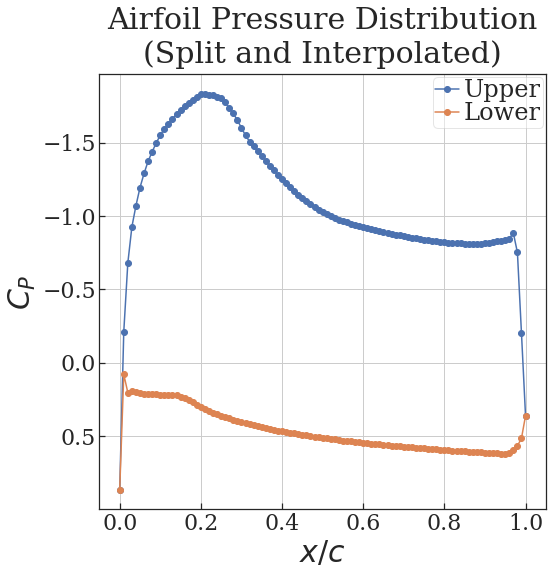

In [166]:
#Split MSES data and Interpolate to new x
Cp_up_interp, Cp_lo_interp = MsesInterp(xnew, xmses, Cp)

#Plot Surface Pressure Distribution
plt.figure()
plt.title('Airfoil Pressure Distribution\n(Split and Interpolated)')
plt.xlabel('$x/c$')
plt.ylabel('$C_P$')

#plot interpolated upper surface pressure
plt.plot(xnew, Cp_up_interp, label='Upper', marker="o")
#plot interpolated lower surface pressure
plt.plot(xnew, Cp_lo_interp, label='Lower', marker="o")

#invert y axis so that upper surface data is on top of plot (more intuitive)
plt.gca().invert_yaxis()
plt.legend()
plt.show()

Now, all of our upper/lower surface data points have a vertically aligned, cooresponding point. Additionally, you will notice that there are many more points in the data set than before.

Both of these changes will improve the accuracy of our calculations.

## Merge 2 Sets of Upper/Lower Surface Data Into MSES Format

Sometime, for working with computational tools like XFOIL or your own panel method code, you may need to reverse the process of MsesSplit() and merge two separate upper and lower surface data sets into one MSES set.

A function for this process is provided below. It joins the two data sets and puts them in the correct order, such that the data is described in a counter-clockwise fashion.

Additionally, it detects and removes a repeated leading edge point, avoiding computational errors to this non-physical possibility.

In [167]:
def MsesMerge(xlo, xup, ylo, yup):
    """ Merge separate upper and lower surface data into single MSES set.
    If LE point is shared by both sides, drop LE from lower set to avoid overlap
    xlo, xup --> lower/upper surface x coordinates to merge
    ylo, yup --> lower/upper surface y OR surface Cp values to merge
    """
    #drop LE point of lower surface if coincident with upper surface
    if xlo[0] == xup[0] and ylo[0] == yup[0]:
    # if xlo[0] == xup[0] and ylo[0] == 0 and yup[0] == 0:
        xlo = xlo[1:]
        ylo = ylo[1:]
    n1 = len(xup)     #number of upper surface points
    n = n1 + len(xlo) #number of upper AND lower surface points
    x, y = np.zeros(n), np.zeros(n)
    #reverse direction of upper surface coordinates
    x[:n1], y[:n1] = xup[-1::-1], yup[-1::-1]
    #append lower surface coordinates as they are
    x[n1:], y[n1:] = xlo, ylo
    return x, y

To demonstrate MsesMerge, let's take our interpolated upper/lower surface data, and convert it to MSES format, and print out the new MSES x-vector:

In [168]:
x_mses_new, Cp_mses_new = MsesMerge(xnew, xnew, Cp_lo_interp, Cp_up_interp)

print('Merged MSES x-vector for interpolated data set:')
print(x_mses_new)

Merged MSES x-vector for interpolated data set:
[1.   0.99 0.98 0.97 0.96 0.95 0.94 0.93 0.92 0.91 0.9  0.89 0.88 0.87
 0.86 0.85 0.84 0.83 0.82 0.81 0.8  0.79 0.78 0.77 0.76 0.75 0.74 0.73
 0.72 0.71 0.7  0.69 0.68 0.67 0.66 0.65 0.64 0.63 0.62 0.61 0.6  0.59
 0.58 0.57 0.56 0.55 0.54 0.53 0.52 0.51 0.5  0.49 0.48 0.47 0.46 0.45
 0.44 0.43 0.42 0.41 0.4  0.39 0.38 0.37 0.36 0.35 0.34 0.33 0.32 0.31
 0.3  0.29 0.28 0.27 0.26 0.25 0.24 0.23 0.22 0.21 0.2  0.19 0.18 0.17
 0.16 0.15 0.14 0.13 0.12 0.11 0.1  0.09 0.08 0.07 0.06 0.05 0.04 0.03
 0.02 0.01 0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11
 0.12 0.13 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25
 0.26 0.27 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39
 0.4  0.41 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53
 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67
 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81
 0.82 0.83 0.84 0.85 0.86 0.8

Notice that the data set runs from 1 to 1, just as in our original MSES data loaded from a text file. Additionally, there is only one point where $\sfrac{x}{c}=0$, so our Leading Edge point was not duplicated.

If we plot the data set, we see the same data points as our previous plot, but now there is no distinction between upper and lower surfaces.

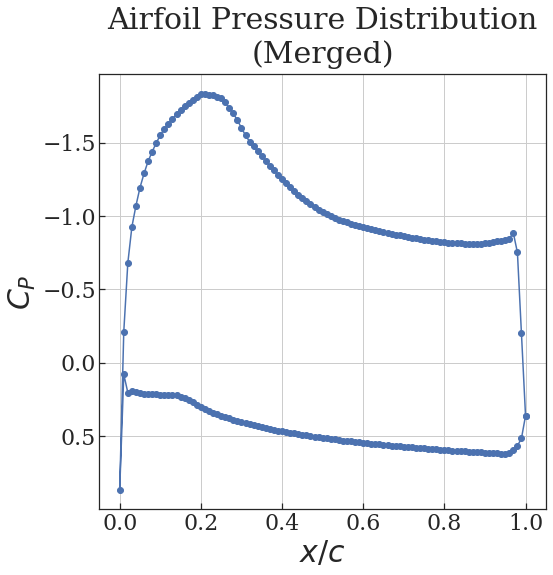

In [169]:
#Plot Surface Pressure Distribution
plt.figure()
plt.title('Airfoil Pressure Distribution\n(Merged)')
plt.xlabel('$x/c$')
plt.ylabel('$C_P$')

plt.plot(x_mses_new, Cp_mses_new, marker="o")
plt.gca().invert_yaxis()
plt.show()